# Use LSTM for Move Review Classification

Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Functions for tokenization and padding

In [3]:
def tokenize(x_train, x_val):
    word_list = []

    # Get a list of all tokens
    for sent in x_train:
        for word in sent.split(): # Already lowercased and punctuation split off in dataset
            word_list.append(word)

    for i in range(1000): # Make sure unknown token is common
        word_list.append('<unk>') # Add an unknown token
    # Get corpus of all words in training data
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:5000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train, final_list_val = [], []
    for sent in x_train:
        sent_list = [onehot_dict[word] if word in onehot_dict.keys() else onehot_dict['<unk>'] for word in sent.split()]
        final_list_train.append(sent_list)

    for sent in x_val:
        sent_list = [onehot_dict[word] if word in onehot_dict.keys() else onehot_dict['<unk>'] for word in sent.split()]
        final_list_val.append(sent_list)

    # 0 pad to have equal length
    #max_len = max([len(i) for i in final_list_train])
    max_len = 500

    for i in range(len(final_list_train)):
        if len(final_list_train[i]) < max_len:
            final_list_train[i] = final_list_train[i] + [0] * (max_len - len(final_list_train[i]))
        elif len(final_list_train[i]) == max_len:
            continue
        else:
            final_list_train[i] = final_list_train[i][:max_len]

    for i in range(len(final_list_val)):
        if len(final_list_val[i]) < max_len:
            final_list_val[i] = final_list_val[i] + [0] * (max_len - len(final_list_val[i]))
        elif len(final_list_val[i]) == max_len:
            continue
        else:
            final_list_val[i] = final_list_val[i][:max_len]


    print(len(final_list_train[0]),len(final_list_train[1]))
    return np.array(final_list_train), np.array(final_list_val), onehot_dict

## Read in data

In [4]:
data_path = 'drive/MyDrive/UMD/MSML641/Project/Data/CornellMovieReview_scale_data'

train = pd.read_csv(f'{data_path}/MovieReviewScaleData_Train_PolarityValence.csv')
val = pd.read_csv(f'{data_path}/MovieReviewScaleData_Val_PolarityValence.csv')
test = pd.read_csv(f'{data_path}/MovieReviewScaleData_Test_PolarityValence.csv')

# See if changing 5 to negative gives better threshold
train.loc[train['Rating'] < 6,'Polarity'] = 0
val.loc[val['Rating'] < 6,'Polarity'] = 0
test.loc[test['Rating'] < 6,'Polarity'] = 0

display(train)

,Review,Rating,ID,Class3,Class4,Author,PolarityScore,Polarity
0,carried away is an incredible film being opene...,8,5986,2,3,Steve+Rhodes,0.165410,1
1,ernest : the one-joke concept that refuses to ...,1,2240,0,0,James+Berardinelli,-0.044428,0
2,"worse still , the only thing about live and le...",5,4553,1,1,James+Berardinelli,0.016052,0
3,ron shelton appears to understand two things b...,9,5831,2,3,Scott+Renshaw,0.210099,1
4,place your foot on the accelerator . watch the...,9,2626,2,3,James+Berardinelli,0.169854,1
...,...,...,...,...,...,...,...,...
3499,it is reported to be a remake of no man of her...,4,5758,0,1,Steve+Rhodes,0.057292,0
3500,"writer and director james l . brooks , who has...",8,10297,2,3,Steve+Rhodes,0.258572,1
3501,"gosh , aren't fart jokes funny ? and if you've...",3,25495,0,0,Steve+Rhodes,0.088385,0
3502,screenplay : jim mcglynn . mpaa rating : r ( p...,7,7512,2,2,Scott+Renshaw,0.264333,1


In [5]:
train['Class3'].value_counts()

,count
Class3,
2,1335
1,1326
0,843


Insert start tokens

In [6]:
for i in range(train.shape[0]):
    review = train['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    train['Review'].iloc[i] = review

for i in range(val.shape[0]):
    review = val['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    val['Review'].iloc[i] = review

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Review'].iloc[i] = review
<ipython-input-6-a6f968306030>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Review'].iloc[i] = review
<ipython-input-6-a6f968306030>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Review'].iloc[i] = review
<ipython-input-6-a6f968306030>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [7]:
train['Polarity'].sum()/train.shape[0]

np.float64(0.5813356164383562)

Tokenize

In [8]:
x_train, x_val, vocab = tokenize(train['Review'],val['Review'])

500 500


In [9]:
x_train.shape,x_val.shape

((3504, 500), (1001, 500))

In [10]:
print(x_train[0])

[   2 3129  304    9   26 1795   17  131 3444 1304  223    1 2930 2176
   31   42  843  186  222  592    4    2    1   17   36  106 1160  275
   31 2207  165    7 2243  165   12   21  156 1222    5  830 4043    3
    7    1  466    5    1  178  246  161  275   14  137    4    2   54
    5   47   11    9    6 3445   17  134  598    6  165   24    4    2
   41 2010  165  572    4    2   18 4044    3  360   29  169    3   16
    9    1  165   51   13  279 1796    4    2  137    3  587   11    9
    3   19   22  100  169   50    4    2   37   36    1   87  179    8
  712  304   45  111    6  165    5  805    3   19 1020    1  165    8
 1078  304   13   35   44    6  101  177    4    2   45   49    1   51
    9    6 1926    5    1  165    7    1  746 1235    4    2    1  924
    5  165   14    1  609    9  442    4    2   33  164    9 1686    5
 1647 2083   10   24    5   33  165  512  564    4    2 1954    3    1
   77  250 2243  165    3   55 1412  107    6   87  132  174  165  165
  165 

In [11]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 5000


## Create data loaders

In [12]:
x_train.shape, train['Rating'].values.squeeze().shape

((3504, 500), (3504,))

In [13]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(train['Class3'].values))
val_data = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(val['Class3'].values))

batch_size = 128
# dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

## Create Model

In [18]:
class SentimentLSTM(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = torch.nn.Linear(hidden_dim, 10)
        self.fc2 = torch.nn.Linear(10,output_dim)

        self.relu = nn.ReLU()


    def forward(self, text):
        # text dim: [sentence length, batch size]

        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1 or 2, batch size, hidden dim]

        hidden.squeeze_(0)

        # hidden dim: [batch size, hidden dim]

        hidden = self.dropout1(hidden)

        output = self.fc1(hidden)
        output = self.relu(output)
        output = self.dropout2(output)

        output = self.fc2(output)

        return output

In [19]:
torch.manual_seed(100)
model = SentimentLSTM(input_dim = len(vocab)+1,
                      embedding_dim = 300,
                      hidden_dim = 64, # 64 best so far
                      output_dim = 3,
)

# Use batch size 128

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.4,1.25,1],dtype=torch.float32)).to(device)

## Train Model

In [20]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

n_epochs = 250

# Train the model
for epoch in tqdm(range(n_epochs)):
    correct_train = 0
    correct_val = 0
    total_train_samples = 0
    total_val_samples = 0
    epoch_loss_train = 0
    epoch_loss_val = 0

    model.train()

    # Train the model
    for text, labels in train_loader:
        text = text.T.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(text)

        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_train += loss.item()

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_train += (pred == labels).sum().item()
        total_train_samples += labels.size(0)

        del text, labels, pred, loss

    train_loss.append(epoch_loss_train)
    train_accuracy = (correct_train / total_train_samples) * 100
    train_acc.append(train_accuracy)

    # Validate
    with torch.no_grad():
        model.eval()

        for text, labels in val_loader:

            text = text.T.to(device)
            labels = labels.to(device)

            pred = model(text)

            loss = criterion(pred, labels)
            epoch_loss_val += loss.item()

            # Calculate accuracy for current batch
            pred = pred.argmax(dim=1)

            correct_val += (pred == labels).sum().item()
            total_val_samples += labels.size(0)

            del text, labels, pred, loss

    val_loss.append(epoch_loss_val)
    val_accuracy = (correct_val / total_val_samples) * 100
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Accuracy: {round(train_accuracy,5)}, Validation Accuracy: {round(val_accuracy,5)}")

  0%|          | 1/250 [00:01<05:59,  1.44s/it]

Epoch 1, Train Accuracy: 29.93721, Validation Accuracy: 32.46753


  1%|          | 2/250 [00:01<03:26,  1.20it/s]

Epoch 2, Train Accuracy: 31.22146, Validation Accuracy: 32.86713


  1%|          | 3/250 [00:02<02:38,  1.56it/s]

Epoch 3, Train Accuracy: 30.50799, Validation Accuracy: 33.16683


  2%|▏         | 4/250 [00:02<02:15,  1.81it/s]

Epoch 4, Train Accuracy: 31.25, Validation Accuracy: 33.56643


  2%|▏         | 5/250 [00:03<02:02,  2.00it/s]

Epoch 5, Train Accuracy: 32.22032, Validation Accuracy: 34.46553


  2%|▏         | 6/250 [00:03<01:54,  2.13it/s]

Epoch 6, Train Accuracy: 32.10616, Validation Accuracy: 34.96503


  3%|▎         | 7/250 [00:03<01:49,  2.22it/s]

Epoch 7, Train Accuracy: 33.33333, Validation Accuracy: 35.86414


  3%|▎         | 8/250 [00:04<01:45,  2.28it/s]

Epoch 8, Train Accuracy: 34.50342, Validation Accuracy: 37.46254


  4%|▎         | 9/250 [00:04<01:44,  2.31it/s]

Epoch 9, Train Accuracy: 36.27283, Validation Accuracy: 37.16284


  4%|▍         | 10/250 [00:05<01:42,  2.34it/s]

Epoch 10, Train Accuracy: 37.07192, Validation Accuracy: 38.26174


  4%|▍         | 11/250 [00:05<01:41,  2.35it/s]

Epoch 11, Train Accuracy: 37.52854, Validation Accuracy: 38.66134


  5%|▍         | 12/250 [00:06<01:41,  2.34it/s]

Epoch 12, Train Accuracy: 38.44178, Validation Accuracy: 39.06094


  5%|▌         | 13/250 [00:06<01:41,  2.34it/s]

Epoch 13, Train Accuracy: 38.81279, Validation Accuracy: 39.56044


  6%|▌         | 14/250 [00:06<01:40,  2.35it/s]

Epoch 14, Train Accuracy: 38.49886, Validation Accuracy: 39.36064


  6%|▌         | 15/250 [00:07<01:40,  2.35it/s]

Epoch 15, Train Accuracy: 39.15525, Validation Accuracy: 39.46054


  6%|▋         | 16/250 [00:07<01:40,  2.33it/s]

Epoch 16, Train Accuracy: 39.75457, Validation Accuracy: 39.66034


  7%|▋         | 17/250 [00:08<01:38,  2.36it/s]

Epoch 17, Train Accuracy: 40.46804, Validation Accuracy: 39.86014


  7%|▋         | 18/250 [00:08<01:37,  2.38it/s]

Epoch 18, Train Accuracy: 40.92466, Validation Accuracy: 39.76024


  8%|▊         | 19/250 [00:08<01:36,  2.39it/s]

Epoch 19, Train Accuracy: 41.06735, Validation Accuracy: 39.96004


  8%|▊         | 20/250 [00:09<01:35,  2.40it/s]

Epoch 20, Train Accuracy: 41.15297, Validation Accuracy: 40.35964


  8%|▊         | 21/250 [00:09<01:35,  2.41it/s]

Epoch 21, Train Accuracy: 41.86644, Validation Accuracy: 40.45954


  9%|▉         | 22/250 [00:10<01:34,  2.41it/s]

Epoch 22, Train Accuracy: 42.2089, Validation Accuracy: 40.55944


  9%|▉         | 23/250 [00:10<01:33,  2.42it/s]

Epoch 23, Train Accuracy: 42.3516, Validation Accuracy: 40.05994


 10%|▉         | 24/250 [00:11<01:34,  2.40it/s]

Epoch 24, Train Accuracy: 42.55137, Validation Accuracy: 40.15984


 10%|█         | 25/250 [00:11<01:33,  2.41it/s]

Epoch 25, Train Accuracy: 42.32306, Validation Accuracy: 40.15984


 10%|█         | 26/250 [00:11<01:33,  2.40it/s]

Epoch 26, Train Accuracy: 42.89384, Validation Accuracy: 40.35964


 11%|█         | 27/250 [00:12<01:32,  2.41it/s]

Epoch 27, Train Accuracy: 43.60731, Validation Accuracy: 40.55944


 11%|█         | 28/250 [00:12<01:32,  2.40it/s]

Epoch 28, Train Accuracy: 43.40753, Validation Accuracy: 40.65934


 12%|█▏        | 29/250 [00:13<01:31,  2.41it/s]

Epoch 29, Train Accuracy: 43.379, Validation Accuracy: 40.65934


 12%|█▏        | 30/250 [00:13<01:31,  2.41it/s]

Epoch 30, Train Accuracy: 45.00571, Validation Accuracy: 40.45954


 12%|█▏        | 31/250 [00:13<01:30,  2.41it/s]

Epoch 31, Train Accuracy: 44.34932, Validation Accuracy: 40.45954


 13%|█▎        | 32/250 [00:14<01:31,  2.39it/s]

Epoch 32, Train Accuracy: 44.60616, Validation Accuracy: 40.15984


 13%|█▎        | 33/250 [00:14<01:30,  2.39it/s]

Epoch 33, Train Accuracy: 44.29224, Validation Accuracy: 40.35964


 14%|█▎        | 34/250 [00:15<01:30,  2.39it/s]

Epoch 34, Train Accuracy: 45.23402, Validation Accuracy: 40.45954


 14%|█▍        | 35/250 [00:15<01:30,  2.39it/s]

Epoch 35, Train Accuracy: 45.43379, Validation Accuracy: 40.15984


 14%|█▍        | 36/250 [00:16<01:30,  2.38it/s]

Epoch 36, Train Accuracy: 45.40525, Validation Accuracy: 39.96004


 15%|█▍        | 37/250 [00:16<01:30,  2.37it/s]

Epoch 37, Train Accuracy: 45.1484, Validation Accuracy: 40.05994


 15%|█▌        | 38/250 [00:16<01:29,  2.37it/s]

Epoch 38, Train Accuracy: 46.09018, Validation Accuracy: 40.35964


 16%|█▌        | 39/250 [00:17<01:29,  2.36it/s]

Epoch 39, Train Accuracy: 45.57648, Validation Accuracy: 39.76024


 16%|█▌        | 40/250 [00:17<01:29,  2.34it/s]

Epoch 40, Train Accuracy: 46.83219, Validation Accuracy: 40.05994


 16%|█▋        | 41/250 [00:18<01:30,  2.32it/s]

Epoch 41, Train Accuracy: 46.88927, Validation Accuracy: 40.35964


 17%|█▋        | 42/250 [00:18<01:29,  2.31it/s]

Epoch 42, Train Accuracy: 47.34589, Validation Accuracy: 39.86014


 17%|█▋        | 43/250 [00:19<01:39,  2.07it/s]

Epoch 43, Train Accuracy: 47.63128, Validation Accuracy: 40.35964


 18%|█▊        | 44/250 [00:19<01:46,  1.93it/s]

Epoch 44, Train Accuracy: 47.34589, Validation Accuracy: 40.15984


 18%|█▊        | 45/250 [00:20<01:58,  1.74it/s]

Epoch 45, Train Accuracy: 48.74429, Validation Accuracy: 40.25974


 18%|█▊        | 46/250 [00:20<01:48,  1.87it/s]

Epoch 46, Train Accuracy: 48.43037, Validation Accuracy: 40.95904


 19%|█▉        | 47/250 [00:21<01:49,  1.86it/s]

Epoch 47, Train Accuracy: 48.4589, Validation Accuracy: 40.85914


 19%|█▉        | 48/250 [00:21<01:42,  1.97it/s]

Epoch 48, Train Accuracy: 49.629, Validation Accuracy: 41.35864


 20%|█▉        | 49/250 [00:22<01:37,  2.06it/s]

Epoch 49, Train Accuracy: 49.14384, Validation Accuracy: 40.95904


 20%|██        | 50/250 [00:22<01:33,  2.13it/s]

Epoch 50, Train Accuracy: 49.77169, Validation Accuracy: 41.65834


 20%|██        | 51/250 [00:23<01:31,  2.18it/s]

Epoch 51, Train Accuracy: 50.54224, Validation Accuracy: 40.75924


 21%|██        | 52/250 [00:23<01:29,  2.21it/s]

Epoch 52, Train Accuracy: 50.85616, Validation Accuracy: 41.15884


 21%|██        | 53/250 [00:24<01:27,  2.24it/s]

Epoch 53, Train Accuracy: 50.59932, Validation Accuracy: 41.15884


 22%|██▏       | 54/250 [00:24<01:26,  2.26it/s]

Epoch 54, Train Accuracy: 50.91324, Validation Accuracy: 41.15884


 22%|██▏       | 55/250 [00:24<01:25,  2.27it/s]

Epoch 55, Train Accuracy: 50.97032, Validation Accuracy: 41.75824


 22%|██▏       | 56/250 [00:25<01:24,  2.29it/s]

Epoch 56, Train Accuracy: 51.56963, Validation Accuracy: 41.35864


 23%|██▎       | 57/250 [00:25<01:24,  2.29it/s]

Epoch 57, Train Accuracy: 51.71233, Validation Accuracy: 41.35864


 23%|██▎       | 58/250 [00:26<01:23,  2.29it/s]

Epoch 58, Train Accuracy: 52.56849, Validation Accuracy: 41.85814


 24%|██▎       | 59/250 [00:26<01:23,  2.29it/s]

Epoch 59, Train Accuracy: 52.4258, Validation Accuracy: 41.75824


 24%|██▍       | 60/250 [00:27<01:22,  2.29it/s]

Epoch 60, Train Accuracy: 52.62557, Validation Accuracy: 41.55844


 24%|██▍       | 61/250 [00:27<01:22,  2.29it/s]

Epoch 61, Train Accuracy: 52.82534, Validation Accuracy: 41.35864


 25%|██▍       | 62/250 [00:28<01:21,  2.30it/s]

Epoch 62, Train Accuracy: 53.42466, Validation Accuracy: 41.45854


 25%|██▌       | 63/250 [00:28<01:21,  2.31it/s]

Epoch 63, Train Accuracy: 52.99658, Validation Accuracy: 41.85814


 26%|██▌       | 64/250 [00:28<01:20,  2.30it/s]

Epoch 64, Train Accuracy: 53.73858, Validation Accuracy: 41.75824


 26%|██▌       | 65/250 [00:29<01:20,  2.29it/s]

Epoch 65, Train Accuracy: 53.99543, Validation Accuracy: 41.75824


 26%|██▋       | 66/250 [00:29<01:20,  2.29it/s]

Epoch 66, Train Accuracy: 52.71119, Validation Accuracy: 40.65934


 27%|██▋       | 67/250 [00:30<01:19,  2.29it/s]

Epoch 67, Train Accuracy: 53.59589, Validation Accuracy: 42.15784


 27%|██▋       | 68/250 [00:30<01:19,  2.29it/s]

Epoch 68, Train Accuracy: 54.45205, Validation Accuracy: 41.65834


 28%|██▊       | 69/250 [00:31<01:19,  2.28it/s]

Epoch 69, Train Accuracy: 54.39498, Validation Accuracy: 41.55844


 28%|██▊       | 70/250 [00:31<01:19,  2.26it/s]

Epoch 70, Train Accuracy: 53.73858, Validation Accuracy: 40.75924


 28%|██▊       | 71/250 [00:32<01:19,  2.25it/s]

Epoch 71, Train Accuracy: 53.90982, Validation Accuracy: 40.85914


 29%|██▉       | 72/250 [00:32<01:19,  2.25it/s]

Epoch 72, Train Accuracy: 54.65183, Validation Accuracy: 41.75824


 29%|██▉       | 73/250 [00:32<01:19,  2.23it/s]

Epoch 73, Train Accuracy: 54.88014, Validation Accuracy: 42.15784


 30%|██▉       | 74/250 [00:33<01:18,  2.23it/s]

Epoch 74, Train Accuracy: 54.7089, Validation Accuracy: 42.15784


 30%|███       | 75/250 [00:33<01:18,  2.23it/s]

Epoch 75, Train Accuracy: 54.56621, Validation Accuracy: 42.25774


 30%|███       | 76/250 [00:34<01:17,  2.25it/s]

Epoch 76, Train Accuracy: 55.2226, Validation Accuracy: 42.25774


 31%|███       | 77/250 [00:34<01:16,  2.25it/s]

Epoch 77, Train Accuracy: 54.88014, Validation Accuracy: 42.15784


 31%|███       | 78/250 [00:35<01:16,  2.26it/s]

Epoch 78, Train Accuracy: 55.10845, Validation Accuracy: 42.25774


 32%|███▏      | 79/250 [00:35<01:15,  2.27it/s]

Epoch 79, Train Accuracy: 55.70776, Validation Accuracy: 42.75724


 32%|███▏      | 80/250 [00:35<01:14,  2.27it/s]

Epoch 80, Train Accuracy: 55.99315, Validation Accuracy: 42.45754


 32%|███▏      | 81/250 [00:36<01:14,  2.28it/s]

Epoch 81, Train Accuracy: 56.16438, Validation Accuracy: 42.25774


 33%|███▎      | 82/250 [00:36<01:13,  2.28it/s]

Epoch 82, Train Accuracy: 55.42237, Validation Accuracy: 42.05794


 33%|███▎      | 83/250 [00:37<01:13,  2.28it/s]

Epoch 83, Train Accuracy: 54.99429, Validation Accuracy: 39.76024


 34%|███▎      | 84/250 [00:37<01:12,  2.28it/s]

Epoch 84, Train Accuracy: 55.56507, Validation Accuracy: 41.15884


 34%|███▍      | 85/250 [00:38<01:12,  2.28it/s]

Epoch 85, Train Accuracy: 55.53653, Validation Accuracy: 42.55744


 34%|███▍      | 86/250 [00:38<01:11,  2.28it/s]

Epoch 86, Train Accuracy: 56.13584, Validation Accuracy: 42.55744


 35%|███▍      | 87/250 [00:39<01:11,  2.28it/s]

Epoch 87, Train Accuracy: 56.42123, Validation Accuracy: 42.15784


 35%|███▌      | 88/250 [00:39<01:11,  2.28it/s]

Epoch 88, Train Accuracy: 56.05023, Validation Accuracy: 41.75824


 36%|███▌      | 89/250 [00:39<01:10,  2.28it/s]

Epoch 89, Train Accuracy: 56.22146, Validation Accuracy: 40.95904


 36%|███▌      | 90/250 [00:40<01:10,  2.27it/s]

Epoch 90, Train Accuracy: 56.67808, Validation Accuracy: 42.25774


 36%|███▋      | 91/250 [00:40<01:09,  2.28it/s]

Epoch 91, Train Accuracy: 56.93493, Validation Accuracy: 42.45754


 37%|███▋      | 92/250 [00:41<01:09,  2.29it/s]

Epoch 92, Train Accuracy: 56.53539, Validation Accuracy: 42.35764


 37%|███▋      | 93/250 [00:41<01:08,  2.29it/s]

Epoch 93, Train Accuracy: 56.42123, Validation Accuracy: 42.15784


 38%|███▊      | 94/250 [00:42<01:08,  2.29it/s]

Epoch 94, Train Accuracy: 56.70662, Validation Accuracy: 41.35864


 38%|███▊      | 95/250 [00:42<01:07,  2.29it/s]

Epoch 95, Train Accuracy: 56.7637, Validation Accuracy: 42.05794


 38%|███▊      | 96/250 [00:43<01:07,  2.29it/s]

Epoch 96, Train Accuracy: 57.02055, Validation Accuracy: 41.95804


 39%|███▉      | 97/250 [00:43<01:06,  2.28it/s]

Epoch 97, Train Accuracy: 57.24886, Validation Accuracy: 42.45754


 39%|███▉      | 98/250 [00:43<01:06,  2.27it/s]

Epoch 98, Train Accuracy: 57.6484, Validation Accuracy: 41.95804


 40%|███▉      | 99/250 [00:44<01:07,  2.25it/s]

Epoch 99, Train Accuracy: 57.56279, Validation Accuracy: 42.75724


 40%|████      | 100/250 [00:44<01:06,  2.24it/s]

Epoch 100, Train Accuracy: 57.96233, Validation Accuracy: 42.85714


 40%|████      | 101/250 [00:45<01:06,  2.23it/s]

Epoch 101, Train Accuracy: 58.53311, Validation Accuracy: 43.25674


 41%|████      | 102/250 [00:45<01:06,  2.22it/s]

Epoch 102, Train Accuracy: 57.99087, Validation Accuracy: 43.45654


 41%|████      | 103/250 [00:46<01:06,  2.22it/s]

Epoch 103, Train Accuracy: 58.53311, Validation Accuracy: 43.15684


 42%|████▏     | 104/250 [00:46<01:06,  2.20it/s]

Epoch 104, Train Accuracy: 58.84703, Validation Accuracy: 43.45654


 42%|████▏     | 105/250 [00:47<01:05,  2.21it/s]

Epoch 105, Train Accuracy: 58.50457, Validation Accuracy: 42.85714


 42%|████▏     | 106/250 [00:47<01:04,  2.22it/s]

Epoch 106, Train Accuracy: 58.53311, Validation Accuracy: 42.65734


 43%|████▎     | 107/250 [00:47<01:03,  2.24it/s]

Epoch 107, Train Accuracy: 58.90411, Validation Accuracy: 43.15684


 43%|████▎     | 108/250 [00:48<01:03,  2.24it/s]

Epoch 108, Train Accuracy: 59.10388, Validation Accuracy: 42.65734


 44%|████▎     | 109/250 [00:48<01:02,  2.25it/s]

Epoch 109, Train Accuracy: 58.76142, Validation Accuracy: 42.75724


 44%|████▍     | 110/250 [00:49<01:01,  2.26it/s]

Epoch 110, Train Accuracy: 58.93265, Validation Accuracy: 42.15784


 44%|████▍     | 111/250 [00:49<01:01,  2.26it/s]

Epoch 111, Train Accuracy: 58.78995, Validation Accuracy: 42.95704


 45%|████▍     | 112/250 [00:50<01:00,  2.26it/s]

Epoch 112, Train Accuracy: 58.73288, Validation Accuracy: 42.35764


 45%|████▌     | 113/250 [00:50<01:00,  2.26it/s]

Epoch 113, Train Accuracy: 59.90297, Validation Accuracy: 42.05794


 46%|████▌     | 114/250 [00:51<01:00,  2.26it/s]

Epoch 114, Train Accuracy: 59.50342, Validation Accuracy: 42.95704


 46%|████▌     | 115/250 [00:51<00:59,  2.26it/s]

Epoch 115, Train Accuracy: 59.61758, Validation Accuracy: 42.85714


 46%|████▋     | 116/250 [00:51<00:59,  2.26it/s]

Epoch 116, Train Accuracy: 59.76027, Validation Accuracy: 42.55744


 47%|████▋     | 117/250 [00:52<00:58,  2.26it/s]

Epoch 117, Train Accuracy: 60.21689, Validation Accuracy: 43.05694


 47%|████▋     | 118/250 [00:52<00:58,  2.27it/s]

Epoch 118, Train Accuracy: 60.18836, Validation Accuracy: 42.95704


 48%|████▊     | 119/250 [00:53<00:57,  2.27it/s]

Epoch 119, Train Accuracy: 60.73059, Validation Accuracy: 43.25674


 48%|████▊     | 120/250 [00:53<00:57,  2.26it/s]

Epoch 120, Train Accuracy: 60.70205, Validation Accuracy: 42.95704


 48%|████▊     | 121/250 [00:54<00:57,  2.26it/s]

Epoch 121, Train Accuracy: 59.96005, Validation Accuracy: 43.35664


 49%|████▉     | 122/250 [00:54<00:56,  2.26it/s]

Epoch 122, Train Accuracy: 60.73059, Validation Accuracy: 42.85714


 49%|████▉     | 123/250 [00:55<00:56,  2.26it/s]

Epoch 123, Train Accuracy: 61.6153, Validation Accuracy: 43.05694


 50%|████▉     | 124/250 [00:55<00:55,  2.26it/s]

Epoch 124, Train Accuracy: 60.93037, Validation Accuracy: 42.35764


 50%|█████     | 125/250 [00:55<00:55,  2.26it/s]

Epoch 125, Train Accuracy: 60.78767, Validation Accuracy: 43.95604


 50%|█████     | 126/250 [00:56<00:54,  2.27it/s]

Epoch 126, Train Accuracy: 61.52968, Validation Accuracy: 41.85814


 51%|█████     | 127/250 [00:56<00:54,  2.27it/s]

Epoch 127, Train Accuracy: 60.44521, Validation Accuracy: 40.75924


 51%|█████     | 128/250 [00:57<00:54,  2.24it/s]

Epoch 128, Train Accuracy: 61.18721, Validation Accuracy: 43.05694


 52%|█████▏    | 129/250 [00:57<00:54,  2.23it/s]

Epoch 129, Train Accuracy: 61.44406, Validation Accuracy: 42.65734


 52%|█████▏    | 130/250 [00:58<00:54,  2.21it/s]

Epoch 130, Train Accuracy: 61.9863, Validation Accuracy: 44.25574


 52%|█████▏    | 131/250 [00:58<00:53,  2.21it/s]

Epoch 131, Train Accuracy: 62.47146, Validation Accuracy: 42.55744


 53%|█████▎    | 132/250 [00:59<00:53,  2.20it/s]

Epoch 132, Train Accuracy: 60.21689, Validation Accuracy: 42.55744


 53%|█████▎    | 133/250 [00:59<00:53,  2.19it/s]

Epoch 133, Train Accuracy: 62.21461, Validation Accuracy: 43.45654


 54%|█████▎    | 134/250 [00:59<00:52,  2.19it/s]

Epoch 134, Train Accuracy: 62.15753, Validation Accuracy: 45.05495


 54%|█████▍    | 135/250 [01:00<00:52,  2.20it/s]

Epoch 135, Train Accuracy: 63.5274, Validation Accuracy: 43.65634


 54%|█████▍    | 136/250 [01:00<00:51,  2.22it/s]

Epoch 136, Train Accuracy: 63.98402, Validation Accuracy: 43.55644


 55%|█████▍    | 137/250 [01:01<00:50,  2.23it/s]

Epoch 137, Train Accuracy: 64.32648, Validation Accuracy: 45.35465


 55%|█████▌    | 138/250 [01:01<00:50,  2.22it/s]

Epoch 138, Train Accuracy: 64.44064, Validation Accuracy: 42.65734


 56%|█████▌    | 139/250 [01:02<00:49,  2.23it/s]

Epoch 139, Train Accuracy: 64.49772, Validation Accuracy: 44.15584


 56%|█████▌    | 140/250 [01:02<00:49,  2.23it/s]

Epoch 140, Train Accuracy: 65.09703, Validation Accuracy: 44.15584


 56%|█████▋    | 141/250 [01:03<00:48,  2.23it/s]

Epoch 141, Train Accuracy: 59.27511, Validation Accuracy: 38.16184


 57%|█████▋    | 142/250 [01:03<00:48,  2.24it/s]

Epoch 142, Train Accuracy: 55.59361, Validation Accuracy: 40.85914


 57%|█████▋    | 143/250 [01:04<00:47,  2.24it/s]

Epoch 143, Train Accuracy: 60.70205, Validation Accuracy: 42.25774


 58%|█████▊    | 144/250 [01:04<00:47,  2.24it/s]

Epoch 144, Train Accuracy: 62.84247, Validation Accuracy: 43.35664


 58%|█████▊    | 145/250 [01:04<00:46,  2.23it/s]

Epoch 145, Train Accuracy: 62.75685, Validation Accuracy: 41.95804


 58%|█████▊    | 146/250 [01:05<00:46,  2.23it/s]

Epoch 146, Train Accuracy: 63.61301, Validation Accuracy: 45.35465


 59%|█████▉    | 147/250 [01:05<00:46,  2.24it/s]

Epoch 147, Train Accuracy: 65.06849, Validation Accuracy: 45.35465


 59%|█████▉    | 148/250 [01:06<00:45,  2.24it/s]

Epoch 148, Train Accuracy: 65.52511, Validation Accuracy: 45.55445


 60%|█████▉    | 149/250 [01:06<00:45,  2.24it/s]

Epoch 149, Train Accuracy: 66.06735, Validation Accuracy: 44.35564


 60%|██████    | 150/250 [01:07<00:44,  2.24it/s]

Epoch 150, Train Accuracy: 65.66781, Validation Accuracy: 45.25475


 60%|██████    | 151/250 [01:07<00:43,  2.25it/s]

Epoch 151, Train Accuracy: 64.06963, Validation Accuracy: 42.65734


 61%|██████    | 152/250 [01:08<00:43,  2.25it/s]

Epoch 152, Train Accuracy: 62.78539, Validation Accuracy: 45.65435


 61%|██████    | 153/250 [01:08<00:43,  2.24it/s]

Epoch 153, Train Accuracy: 66.69521, Validation Accuracy: 44.95504


 62%|██████▏   | 154/250 [01:08<00:42,  2.24it/s]

Epoch 154, Train Accuracy: 66.46689, Validation Accuracy: 44.45554


 62%|██████▏   | 155/250 [01:09<00:42,  2.24it/s]

Epoch 155, Train Accuracy: 66.40982, Validation Accuracy: 45.45455


 62%|██████▏   | 156/250 [01:09<00:41,  2.24it/s]

Epoch 156, Train Accuracy: 66.49543, Validation Accuracy: 44.55544


 63%|██████▎   | 157/250 [01:10<00:41,  2.22it/s]

Epoch 157, Train Accuracy: 66.72374, Validation Accuracy: 44.75524


 63%|██████▎   | 158/250 [01:10<00:41,  2.19it/s]

Epoch 158, Train Accuracy: 66.66667, Validation Accuracy: 42.75724


 64%|██████▎   | 159/250 [01:11<00:41,  2.19it/s]

Epoch 159, Train Accuracy: 66.06735, Validation Accuracy: 43.85614


 64%|██████▍   | 160/250 [01:11<00:41,  2.19it/s]

Epoch 160, Train Accuracy: 68.00799, Validation Accuracy: 43.65634


 64%|██████▍   | 161/250 [01:12<00:40,  2.18it/s]

Epoch 161, Train Accuracy: 66.43836, Validation Accuracy: 45.25475


 65%|██████▍   | 162/250 [01:12<00:40,  2.18it/s]

Epoch 162, Train Accuracy: 66.69521, Validation Accuracy: 45.45455


 65%|██████▌   | 163/250 [01:13<00:39,  2.18it/s]

Epoch 163, Train Accuracy: 66.95205, Validation Accuracy: 42.45754


 66%|██████▌   | 164/250 [01:13<00:39,  2.19it/s]

Epoch 164, Train Accuracy: 65.32534, Validation Accuracy: 43.65634


 66%|██████▌   | 165/250 [01:13<00:38,  2.20it/s]

Epoch 165, Train Accuracy: 66.8379, Validation Accuracy: 45.05495


 66%|██████▋   | 166/250 [01:14<00:38,  2.21it/s]

Epoch 166, Train Accuracy: 66.52397, Validation Accuracy: 45.45455


 67%|██████▋   | 167/250 [01:14<00:37,  2.22it/s]

Epoch 167, Train Accuracy: 68.35046, Validation Accuracy: 45.15485


 67%|██████▋   | 168/250 [01:15<00:36,  2.22it/s]

Epoch 168, Train Accuracy: 69.23516, Validation Accuracy: 44.65534


 68%|██████▊   | 169/250 [01:15<00:36,  2.23it/s]

Epoch 169, Train Accuracy: 69.23516, Validation Accuracy: 45.35465


 68%|██████▊   | 170/250 [01:16<00:36,  2.22it/s]

Epoch 170, Train Accuracy: 68.80708, Validation Accuracy: 45.55445


 68%|██████▊   | 171/250 [01:16<00:35,  2.22it/s]

Epoch 171, Train Accuracy: 68.83562, Validation Accuracy: 45.05495


 69%|██████▉   | 172/250 [01:17<00:35,  2.22it/s]

Epoch 172, Train Accuracy: 69.121, Validation Accuracy: 44.45554


 69%|██████▉   | 173/250 [01:17<00:34,  2.23it/s]

Epoch 173, Train Accuracy: 68.43607, Validation Accuracy: 44.95504


 70%|██████▉   | 174/250 [01:17<00:34,  2.23it/s]

Epoch 174, Train Accuracy: 68.49315, Validation Accuracy: 45.55445


 70%|███████   | 175/250 [01:18<00:33,  2.23it/s]

Epoch 175, Train Accuracy: 69.37785, Validation Accuracy: 45.45455


 70%|███████   | 176/250 [01:18<00:33,  2.23it/s]

Epoch 176, Train Accuracy: 69.83447, Validation Accuracy: 45.35465


 71%|███████   | 177/250 [01:19<00:32,  2.23it/s]

Epoch 177, Train Accuracy: 69.29224, Validation Accuracy: 45.05495


 71%|███████   | 178/250 [01:19<00:32,  2.23it/s]

Epoch 178, Train Accuracy: 70.11986, Validation Accuracy: 45.45455


 72%|███████▏  | 179/250 [01:20<00:31,  2.23it/s]

Epoch 179, Train Accuracy: 70.00571, Validation Accuracy: 45.15485


 72%|███████▏  | 180/250 [01:20<00:31,  2.23it/s]

Epoch 180, Train Accuracy: 64.78311, Validation Accuracy: 37.16284


 72%|███████▏  | 181/250 [01:21<00:30,  2.23it/s]

Epoch 181, Train Accuracy: 48.14498, Validation Accuracy: 38.76124


 73%|███████▎  | 182/250 [01:21<00:30,  2.22it/s]

Epoch 182, Train Accuracy: 55.30822, Validation Accuracy: 40.35964


 73%|███████▎  | 183/250 [01:22<00:30,  2.22it/s]

Epoch 183, Train Accuracy: 57.7911, Validation Accuracy: 41.15884


 74%|███████▎  | 184/250 [01:22<00:29,  2.22it/s]

Epoch 184, Train Accuracy: 59.30365, Validation Accuracy: 40.85914


 74%|███████▍  | 185/250 [01:22<00:29,  2.22it/s]

Epoch 185, Train Accuracy: 60.90183, Validation Accuracy: 42.35764


 74%|███████▍  | 186/250 [01:23<00:29,  2.20it/s]

Epoch 186, Train Accuracy: 62.04338, Validation Accuracy: 42.95704


 75%|███████▍  | 187/250 [01:23<00:28,  2.19it/s]

Epoch 187, Train Accuracy: 63.09932, Validation Accuracy: 43.45654


 75%|███████▌  | 188/250 [01:24<00:28,  2.18it/s]

Epoch 188, Train Accuracy: 63.24201, Validation Accuracy: 43.35664


 76%|███████▌  | 189/250 [01:24<00:28,  2.18it/s]

Epoch 189, Train Accuracy: 64.55479, Validation Accuracy: 43.05694


 76%|███████▌  | 190/250 [01:25<00:27,  2.17it/s]

Epoch 190, Train Accuracy: 65.75342, Validation Accuracy: 43.45654


 76%|███████▋  | 191/250 [01:25<00:27,  2.16it/s]

Epoch 191, Train Accuracy: 66.26712, Validation Accuracy: 44.15584


 77%|███████▋  | 192/250 [01:26<00:26,  2.17it/s]

Epoch 192, Train Accuracy: 66.69521, Validation Accuracy: 44.15584


 77%|███████▋  | 193/250 [01:26<00:26,  2.19it/s]

Epoch 193, Train Accuracy: 66.80936, Validation Accuracy: 44.05594


 78%|███████▊  | 194/250 [01:27<00:25,  2.19it/s]

Epoch 194, Train Accuracy: 67.26598, Validation Accuracy: 44.45554


 78%|███████▊  | 195/250 [01:27<00:25,  2.20it/s]

Epoch 195, Train Accuracy: 69.00685, Validation Accuracy: 44.75524


 78%|███████▊  | 196/250 [01:27<00:24,  2.20it/s]

Epoch 196, Train Accuracy: 68.83562, Validation Accuracy: 43.75624


 79%|███████▉  | 197/250 [01:28<00:24,  2.20it/s]

Epoch 197, Train Accuracy: 68.00799, Validation Accuracy: 44.65534


 79%|███████▉  | 198/250 [01:28<00:23,  2.20it/s]

Epoch 198, Train Accuracy: 69.57763, Validation Accuracy: 44.45554


 80%|███████▉  | 199/250 [01:29<00:23,  2.21it/s]

Epoch 199, Train Accuracy: 69.7774, Validation Accuracy: 44.35564


 80%|████████  | 200/250 [01:29<00:22,  2.21it/s]

Epoch 200, Train Accuracy: 70.60502, Validation Accuracy: 44.95504


 80%|████████  | 201/250 [01:30<00:22,  2.20it/s]

Epoch 201, Train Accuracy: 69.92009, Validation Accuracy: 45.15485


 81%|████████  | 202/250 [01:30<00:21,  2.21it/s]

Epoch 202, Train Accuracy: 69.92009, Validation Accuracy: 43.15684


 81%|████████  | 203/250 [01:31<00:21,  2.21it/s]

Epoch 203, Train Accuracy: 68.43607, Validation Accuracy: 46.15385


 82%|████████▏ | 204/250 [01:31<00:20,  2.21it/s]

Epoch 204, Train Accuracy: 69.83447, Validation Accuracy: 44.85514


 82%|████████▏ | 205/250 [01:32<00:20,  2.21it/s]

Epoch 205, Train Accuracy: 70.31963, Validation Accuracy: 45.95405


 82%|████████▏ | 206/250 [01:32<00:19,  2.20it/s]

Epoch 206, Train Accuracy: 70.80479, Validation Accuracy: 45.85415


 83%|████████▎ | 207/250 [01:32<00:19,  2.20it/s]

Epoch 207, Train Accuracy: 70.43379, Validation Accuracy: 45.55445


 83%|████████▎ | 208/250 [01:33<00:19,  2.20it/s]

Epoch 208, Train Accuracy: 71.00457, Validation Accuracy: 45.25475


 84%|████████▎ | 209/250 [01:33<00:18,  2.20it/s]

Epoch 209, Train Accuracy: 71.40411, Validation Accuracy: 45.75425


 84%|████████▍ | 210/250 [01:34<00:18,  2.20it/s]

Epoch 210, Train Accuracy: 69.86301, Validation Accuracy: 45.15485


 84%|████████▍ | 211/250 [01:34<00:17,  2.20it/s]

Epoch 211, Train Accuracy: 71.00457, Validation Accuracy: 45.35465


 85%|████████▍ | 212/250 [01:35<00:17,  2.21it/s]

Epoch 212, Train Accuracy: 71.43265, Validation Accuracy: 45.15485


 85%|████████▌ | 213/250 [01:35<00:16,  2.20it/s]

Epoch 213, Train Accuracy: 71.46119, Validation Accuracy: 44.65534


 86%|████████▌ | 214/250 [01:36<00:16,  2.19it/s]

Epoch 214, Train Accuracy: 71.03311, Validation Accuracy: 45.45455


 86%|████████▌ | 215/250 [01:36<00:16,  2.18it/s]

Epoch 215, Train Accuracy: 71.83219, Validation Accuracy: 45.45455


 86%|████████▋ | 216/250 [01:37<00:16,  2.12it/s]

Epoch 216, Train Accuracy: 72.23174, Validation Accuracy: 45.65435


 87%|████████▋ | 217/250 [01:37<00:19,  1.74it/s]

Epoch 217, Train Accuracy: 71.91781, Validation Accuracy: 45.45455


 87%|████████▋ | 218/250 [01:38<00:17,  1.84it/s]

Epoch 218, Train Accuracy: 71.74658, Validation Accuracy: 45.95405


 88%|████████▊ | 219/250 [01:38<00:16,  1.91it/s]

Epoch 219, Train Accuracy: 71.48973, Validation Accuracy: 44.55544


 88%|████████▊ | 220/250 [01:39<00:15,  1.99it/s]

Epoch 220, Train Accuracy: 71.77511, Validation Accuracy: 44.95504


 88%|████████▊ | 221/250 [01:39<00:14,  2.04it/s]

Epoch 221, Train Accuracy: 71.86073, Validation Accuracy: 45.45455


 89%|████████▉ | 222/250 [01:40<00:13,  2.08it/s]

Epoch 222, Train Accuracy: 71.00457, Validation Accuracy: 43.65634


 89%|████████▉ | 223/250 [01:40<00:12,  2.12it/s]

Epoch 223, Train Accuracy: 70.37671, Validation Accuracy: 46.05395


 90%|████████▉ | 224/250 [01:41<00:12,  2.14it/s]

Epoch 224, Train Accuracy: 72.00342, Validation Accuracy: 45.15485


 90%|█████████ | 225/250 [01:41<00:11,  2.16it/s]

Epoch 225, Train Accuracy: 72.71689, Validation Accuracy: 45.15485


 90%|█████████ | 226/250 [01:42<00:11,  2.17it/s]

Epoch 226, Train Accuracy: 71.94635, Validation Accuracy: 44.95504


 91%|█████████ | 227/250 [01:42<00:10,  2.17it/s]

Epoch 227, Train Accuracy: 73.40183, Validation Accuracy: 45.45455


 91%|█████████ | 228/250 [01:42<00:10,  2.18it/s]

Epoch 228, Train Accuracy: 73.14498, Validation Accuracy: 45.45455


 92%|█████████▏| 229/250 [01:43<00:09,  2.19it/s]

Epoch 229, Train Accuracy: 72.40297, Validation Accuracy: 44.55544


 92%|█████████▏| 230/250 [01:43<00:09,  2.18it/s]

Epoch 230, Train Accuracy: 72.51712, Validation Accuracy: 45.35465


 92%|█████████▏| 231/250 [01:44<00:08,  2.18it/s]

Epoch 231, Train Accuracy: 73.51598, Validation Accuracy: 45.75425


 93%|█████████▎| 232/250 [01:44<00:08,  2.19it/s]

Epoch 232, Train Accuracy: 72.65982, Validation Accuracy: 45.65435


 93%|█████████▎| 233/250 [01:45<00:07,  2.19it/s]

Epoch 233, Train Accuracy: 72.37443, Validation Accuracy: 45.75425


 94%|█████████▎| 234/250 [01:45<00:07,  2.19it/s]

Epoch 234, Train Accuracy: 73.40183, Validation Accuracy: 45.25475


 94%|█████████▍| 235/250 [01:46<00:06,  2.19it/s]

Epoch 235, Train Accuracy: 73.20205, Validation Accuracy: 43.45654


 94%|█████████▍| 236/250 [01:46<00:06,  2.19it/s]

Epoch 236, Train Accuracy: 73.17352, Validation Accuracy: 42.65734


 95%|█████████▍| 237/250 [01:47<00:05,  2.19it/s]

Epoch 237, Train Accuracy: 71.97489, Validation Accuracy: 43.85614


 95%|█████████▌| 238/250 [01:47<00:05,  2.19it/s]

Epoch 238, Train Accuracy: 72.65982, Validation Accuracy: 44.95504


 96%|█████████▌| 239/250 [01:47<00:05,  2.19it/s]

Epoch 239, Train Accuracy: 72.74543, Validation Accuracy: 42.75724


 96%|█████████▌| 240/250 [01:48<00:04,  2.19it/s]

Epoch 240, Train Accuracy: 72.94521, Validation Accuracy: 44.65534


 96%|█████████▋| 241/250 [01:48<00:04,  2.19it/s]

Epoch 241, Train Accuracy: 72.54566, Validation Accuracy: 43.75624


 97%|█████████▋| 242/250 [01:49<00:03,  2.18it/s]

Epoch 242, Train Accuracy: 72.48858, Validation Accuracy: 44.55544


 97%|█████████▋| 243/250 [01:49<00:03,  2.16it/s]

Epoch 243, Train Accuracy: 72.74543, Validation Accuracy: 42.25774


 98%|█████████▊| 244/250 [01:50<00:02,  2.15it/s]

Epoch 244, Train Accuracy: 73.77283, Validation Accuracy: 44.65534


 98%|█████████▊| 245/250 [01:50<00:02,  2.15it/s]

Epoch 245, Train Accuracy: 73.31621, Validation Accuracy: 40.25974


 98%|█████████▊| 246/250 [01:51<00:01,  2.14it/s]

Epoch 246, Train Accuracy: 74.37215, Validation Accuracy: 42.75724


 99%|█████████▉| 247/250 [01:51<00:01,  2.14it/s]

Epoch 247, Train Accuracy: 73.28767, Validation Accuracy: 42.85714


 99%|█████████▉| 248/250 [01:52<00:00,  2.13it/s]

Epoch 248, Train Accuracy: 74.05822, Validation Accuracy: 40.85914


100%|█████████▉| 249/250 [01:52<00:00,  2.15it/s]

Epoch 249, Train Accuracy: 74.51484, Validation Accuracy: 41.75824


100%|██████████| 250/250 [01:53<00:00,  2.21it/s]

Epoch 250, Train Accuracy: 73.05936, Validation Accuracy: 43.85614


## Plot results

Loss

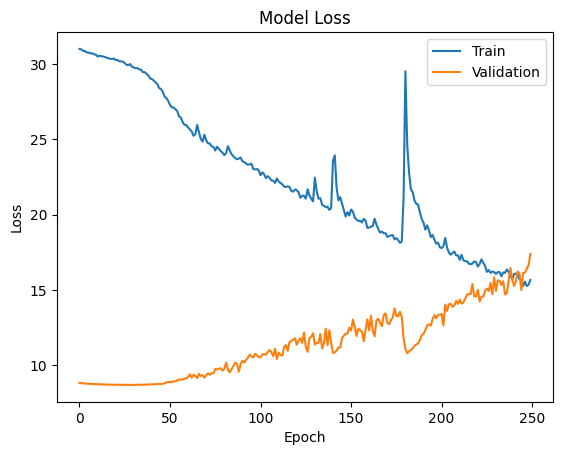

In [21]:
plt.title('Model Loss')
plt.plot([i for i in range(n_epochs)], train_loss,label='Train')
plt.plot([i for i in range(n_epochs)], val_loss,label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

Accuracy

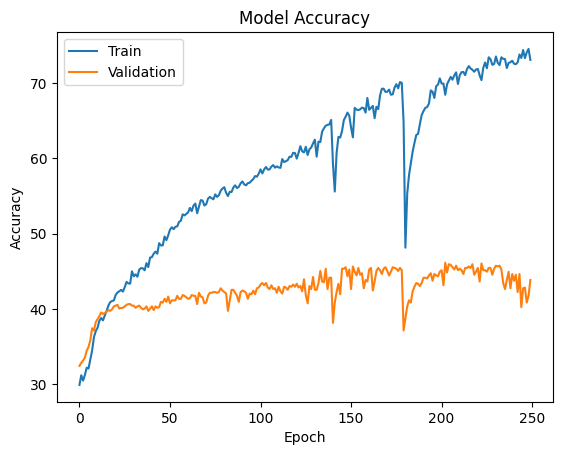

In [22]:
plt.title('Model Accuracy')
plt.plot([i for i in range(n_epochs)], train_acc, label='Train')
plt.plot([i for i in range(n_epochs)], val_acc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

Get Train Predictions

In [23]:
# Validate
with torch.no_grad():
    model.eval()

    i=0
    for text, labels in train_loader:

        text = text.T.to(device)
        labels = labels.to(device)

        pred = model(text)

        loss = criterion(pred, labels)
        val_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_val += (pred == labels).sum().item()
        total_val_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del text, labels, pred, loss

val_accuracy = (correct_val / total_val_samples) * 100
print(f"Final train accuracy:", val_accuracy)

Final train accuracy: 67.6581576026637


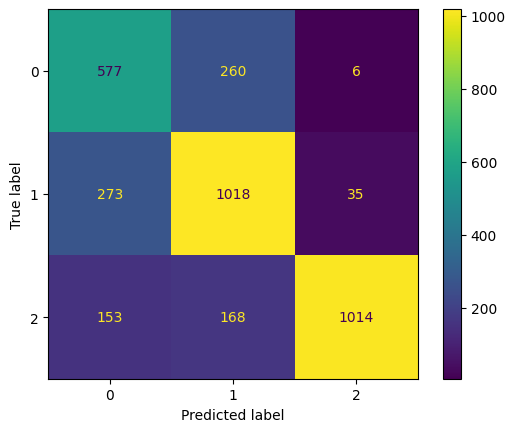

In [24]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Get Validation Predictions

In [25]:
# Validate
with torch.no_grad():
    model.eval()

    i=0
    for text, labels in val_loader:

        text = text.T.to(device)
        labels = labels.to(device)

        pred = model(text)

        loss = criterion(pred, labels)
        val_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_val += (pred == labels).sum().item()
        total_val_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del text, labels, pred, loss

val_accuracy = (correct_val / total_val_samples) * 100
print(f"Final validation accuracy:", val_accuracy)

Final validation accuracy: 63.33091173265528


Confusion Matrix

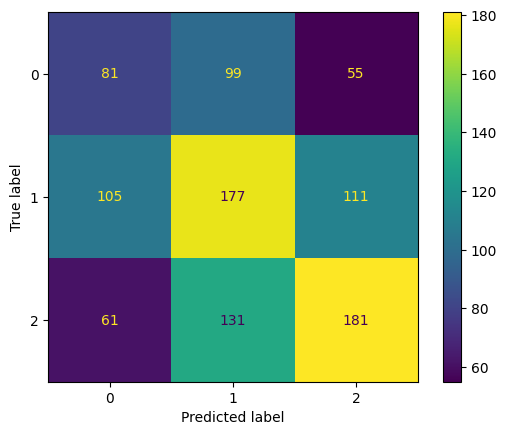

In [26]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [27]:
f1 = f1_score(all_labels, all_pred, average = 'weighted')
print(f"F1 score: {f1}")

F1 score: 0.4399820315691685


# Get test Results

In [28]:
for i in range(test.shape[0]):
    review = test['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    test['Review'].iloc[i] = review

<ipython-input-28-a77be1b26ecf>:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test['Review'].iloc[i] = review
<ipython-input-28-a77be1b26ecf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [29]:
x_train, x_test, vocab = tokenize(train['Review'],test['Review'])
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(test['Class3'].values))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

500 500


In [30]:
# Validate
test_loss = []
correct_test = 0
total_test_samples = 0
with torch.no_grad():
    model.eval()

    i=0
    for text, labels in test_loader:

        text = text.T.to(device)
        labels = labels.to(device)

        pred = model(text)

        loss = criterion(pred, labels)
        test_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_test += (pred == labels).sum().item()
        total_test_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del text, labels, pred, loss

test_accuracy = (correct_test / total_test_samples) * 100
print(f"Final test accuracy:", test_accuracy)

Final test accuracy: 47.50499001996008


Test confusion matrix

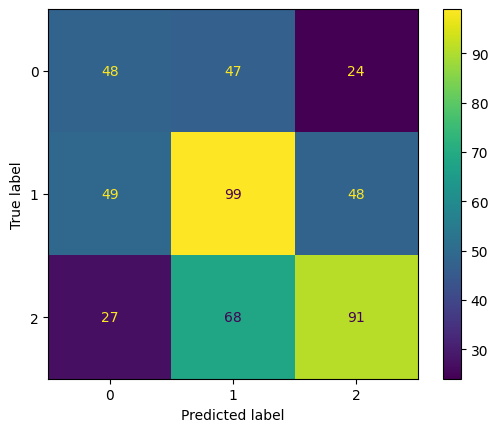

In [31]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Test f1 score

In [32]:
f1_score(all_labels, all_pred,average='weighted')

0.4763735307107481